In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from behav import plotting, utils, loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [35]:
from cdcp.experiment_info import subjects
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
from cdcp.behavior.data import prepare_behavior_data
from cdcp.visualization.colors import colors
subjects, DATA_PATH_MAGPI

(('B1174',
  'B1426',
  'B1170',
  'B1432',
  'B1437',
  'B1433',
  'B1597',
  'B1427',
  'B1188',
  'B1244'),
 PosixPath('/mnt/cube/RawData/Magpi'))

### Fit Bayesian model to each bird

The probability of a stimulus being in a given position can be described by Bayes rule:

$$ 
\underbrace{P(x_{true}\mid x_{sensed},cue)}_\text{posterior} \propto \underbrace{P(x_{sensed} \mid x_{true}, cue)}_\text{likelihood}\underbrace{P(x_{true} \mid cue)}_\text{prior}
$$

Where $cue$ refers to a contextual cue. By controlling a shift the posterior of the distribution, $P(x_{sensed} \mid x_{true}, cue)$, the perception $x$ will shift as well.

We can treat the likelihood $P(x_{sensed} \mid x_{true}, cue)$ as a Gaussian probability distribution around the true stimuli $x_{true}$ as in Kording et al.,

$$
P ( x_{sensed} \mid x_{true}) =  \frac { 1} { \sigma \sqrt { 2\pi } } e ^ { - \frac { 1} { 2} \left( \frac { x_{true} - x_{sensed} } { \sigma_{sensed} } \right) ^ { 2} } 
$$

Where $\sigma_{sensed}$ represents the uncertainty in the position and must be estimated

We can treat $p(x _{true} \mid cue)$ as a step function, representing the prior probability to a stimulus related to the cue which is baked into the behavioral task

$$
P(x_{true} \mid cue) = \begin{cases} 
      cue_{prob} & x_{true} \geq 62 \\
      1-cue_{prob} & x_{true} < 62
\end{cases}
$$

Finally, we can represent the birds decision as the posterior probability of any stimulus, multiplied by a decision boundary, also baked into the behavioral task

$$
decision(x_{true}, x_{sensed}) = P(x_{true}\mid x_{sensed}, cue)  category(x_{true})
$$

Where $category(x_{true})$ is simply the trained category label of $x$ in the 2AC task: 

$$
category(x_{true}) = \begin{cases} 
      0 & x_{true} \geq 62 \\
      1 & x_{true} < 62
\end{cases}
$$

However we need to account for 
- the side biases of the bird ($\gamma$, the tendency of the bird to choose one peckport over the other)
Which independantly affects
- the overall innattentivity all stimuli ($\alpha$)
- the overall innattentivity to the categorical stimuli ($\beta$)
- the overall innattentivity to cue stimuli ($\delta$)

$$
bias_{side}(\gamma) = category(x_{true})(1-2(1-\gamma))+1-\gamma
$$

$$
likelihood =  likelihood(1 - \beta)  + bias_{side}(\gamma)\beta 
$$

$$ 
posterior \propto posterior(1 - \alpha)  +  bias_{side}(\gamma)\alpha
$$

$$ 
prior = prior(1 - \delta)  +  bias_{side}(\gamma)\delta
$$

#### Set the baked in parameters

In [4]:
x_true = np.arange(128)
decision_boundary = np.zeros(len(x_true))
decision_boundary[x_true > 63] = 1

In [5]:
condition_types = [0.125, 0.25, 0.5, 0.75, 0.875]
midpoint = 63
prior_probability = {ct: np.zeros(len(x_true))+ct for ct in condition_types}
for ct in condition_types: prior_probability[ct][x_true > midpoint]  = 1-ct 

Text(0, 0.5, 'Class')

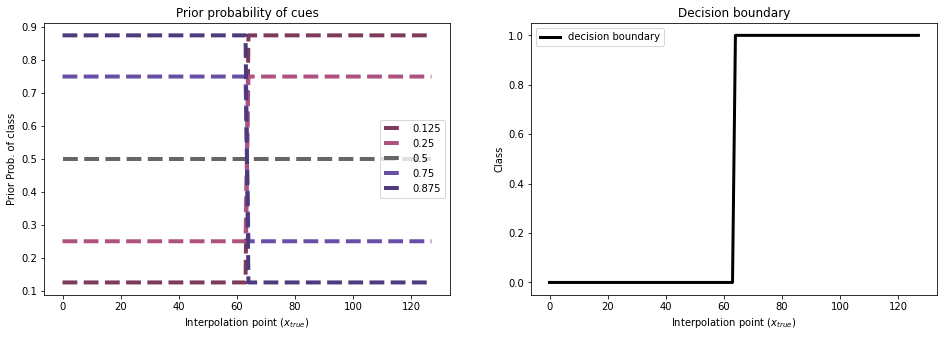

In [92]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(2*8,5))
cue_plots = []
for ct in condition_types:
    cue_plots.append(axs[0].plot(x_true,prior_probability[ct], color = colors['cue']['L'][ct], lw= 4, ls='--', label = ct)[0])
axs[0].legend(cue_plots, condition_types)
axs[0].set_title('Prior probability of cues')
axs[0].set_xlabel('Interpolation point ($x_{true}$)')
axs[0].set_ylabel('Prior Prob. of class')
decb = axs[1].plot(x_true, decision_boundary, color = 'k', lw='3')
axs[1].legend(decb, ['decision boundary'])
axs[1].set_title('Decision boundary')
axs[1].set_xlabel('Interpolation point ($x_{true}$)')
axs[1].set_ylabel('Class')

#### Define the model

In [93]:
from cdcp.behavior.bayesian import bayesian_model

In [8]:
#plt.plot(side_bias(.3, decision_boundary))

In [66]:
params = {
    'sigma_likelihood':10, # std of gaussian for likelihood
    'beta_categorical_attention': 0, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':.1, # pct of time ignoring the cue
    'alpha_overall_attention':.2, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}

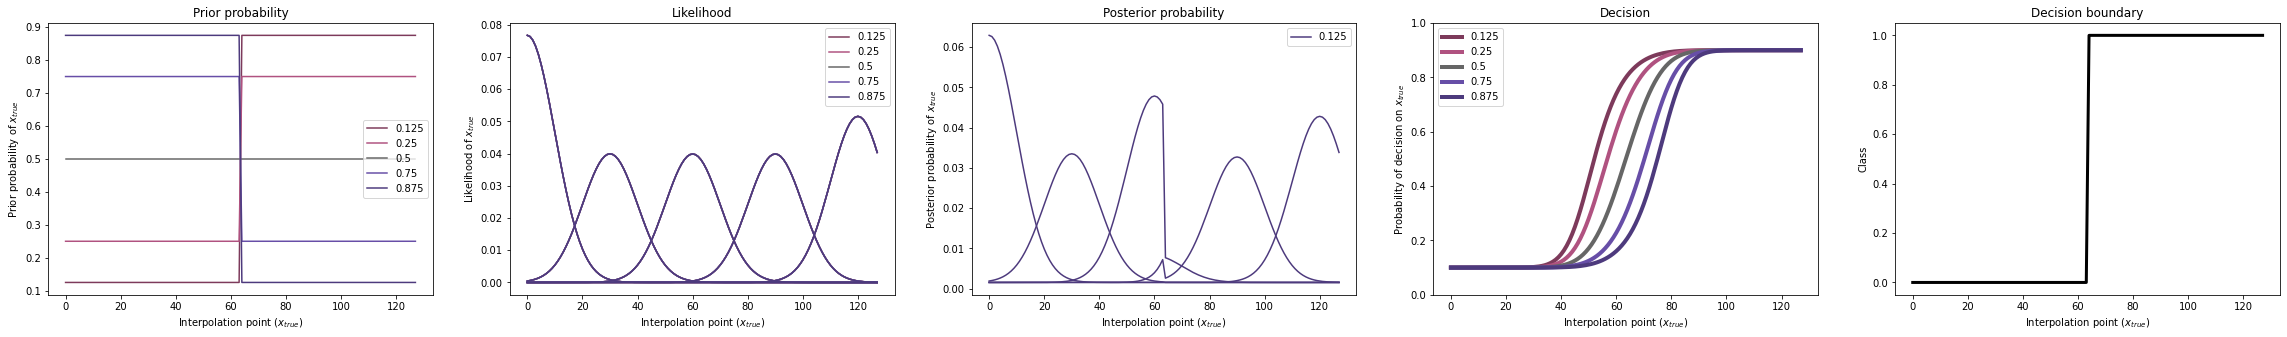

In [67]:
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(5*8,5))
decision_plots = []
posterior_plots = []
likelihood_plots = []
cue_plots = []

# plot
for ct in condition_types:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    cue_plots.append(axs[0].plot(x_true,prior_probability[ct], color = colors['cue']['L'][ct], label = ct)[0])
    likelihood_plots.append(axs[1].plot(likelihood[::30].T, color = colors['cue']['L'][ct])[0])
    decision_plots.append(axs[3].plot(x_true, decision, color = colors['cue']['L'][ct], lw= 4, label = ct)[0])
posterior_plots.append(axs[2].plot(posterior_probability[::30].T, color = colors['cue']['L'][ct])[0])
decb = axs[4].plot(x_true, decision_boundary, color = 'k', lw='3')
for ax in axs.reshape(-1):
    ax.set_xlabel('Interpolation point ($x_{true}$)')

axs[0].set_title('Prior probability')
axs[1].set_title('Likelihood')
axs[2].set_title('Posterior probability')
axs[3].set_title('Decision')
axs[4].set_title('Decision boundary')

axs[0].set_ylabel('Prior probability of $x_{true}$')
axs[1].set_ylabel('Likelihood of $x_{true}$')
axs[2].set_ylabel('Posterior probability of $x_{true}$')
axs[3].set_ylabel('Probability of decision on $x_{true}$')
axs[4].set_ylabel('Class')
    
axs[3].set_ylim([0,1])
# legends
for axi, plts in enumerate([cue_plots, likelihood_plots, posterior_plots, decision_plots]):
    axs[axi].legend(plts, condition_types)
plt.show()

In [68]:
condition_types

[0.125, 0.25, 0.5, 0.75, 0.875]

In [12]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


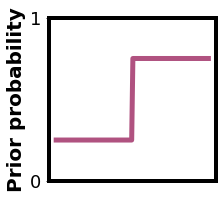

In [54]:
fig, ax = plt.subplots(figsize=(3,3))

cue_plots = []

# plot
for ct in condition_types[1:2]:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true,prior_probability[ct], color = colors['cue']['L'][ct], label = ct, lw = 5)

#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
ax.set_yticks([0,1])

ax.set_ylabel('Prior probability', fontsize=20, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=18)

    
ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'prior', save_pdf=True)
plt.show()


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':


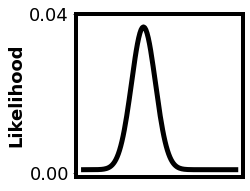

In [65]:
fig, ax = plt.subplots(figsize=(3,3))

cue_plots = []

# plot
for ct in condition_types[1:2]:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    #ax.plot(x_true,prior_probability[ct], color = colors['cue']['L'][ct], label = ct, lw = 10)
    ax.plot(likelihood[50].T, color = 'k', lw=5)
    
#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
#ax.set_yticks([0,1])
ax.set_yticks([0,0.04])

ax.set_ylabel('Likelihood', fontsize=18, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=18)

    
#ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'likelihood', save_pdf=True)
plt.show()


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


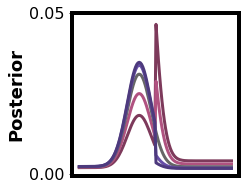

In [64]:
fig, ax = plt.subplots(figsize=(3,3))

cue_plots = []

# plot
for ct in condition_types:#[1:2]:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(posterior_probability[50].T, color = colors['cue']['L'][ct], lw=3)
    
#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
#ax.set_yticks([0,1])
ax.set_yticks([0,0.05])

ax.set_ylabel('Posterior', fontsize=18, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=16)

    
#ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'posterior', save_pdf=True)
plt.show()


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':


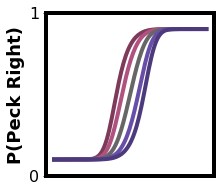

In [73]:
fig, ax = plt.subplots(figsize=(3,3))

cue_plots = []

# plot
for ct in condition_types:#[1:2]:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true, decision, color = colors['cue']['L'][ct], lw= 4, label = ct)

    
#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
#ax.set_yticks([0,1])
ax.set_yticks([0,1])

ax.set_ylabel('P(Peck Right)', fontsize=18, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=16)

    
#ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'decision', save_pdf=True)
plt.show()


In [90]:
params_no_integration = {
    'sigma_likelihood':10, # std of gaussian for likelihood
    'beta_categorical_attention': 0.1, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':0.1, # pct of time ignoring the cue
    'alpha_overall_attention':0.1, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':


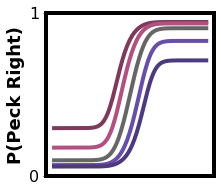

In [91]:
fig, ax = plt.subplots(figsize=(3,3))

cue_plots = []

# plot
for ct in condition_types:#[1:2]:
    decision, posterior_probability, likelihood = bayesian_model(params_no_integration, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true, decision, color = colors['cue']['L'][ct], lw= 4, label = ct)

    
#ax.set_xlabel('Interpolation point ($x_{true}$)')
ax.set_xticks([], [])
#ax.set_yticks([0,1])
ax.set_yticks([0,1])

ax.set_ylabel('P(Peck Right)', fontsize=18, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=16)

    
#ax.set_ylim([0,1])
# legends
#ax.legend()
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'decision_no_integration', save_pdf=True)
plt.show()


In [115]:
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  after removing the cwd from sys.path.
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


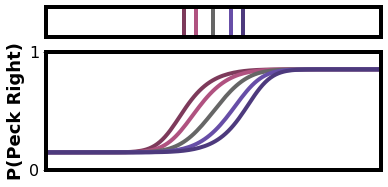

In [117]:
fig, axs = plt.subplots(nrows=2, figsize=(6,3),gridspec_kw={'height_ratios': [1, 4]})

ax = axs[0]
ax.set_xticks([], [])
ax.set_yticks([])
plt.tick_params(axis='both', which='major', labelsize=16)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_xlim([0,127])

ax = axs[1]
ax.set_ylabel('P(Peck Right)', fontsize=18, fontweight='bold')
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis='both', which='major', labelsize=16)


ax.set_xticks([], [])
ax.set_yticks([0,1])
ax.set_xlim([0,127])
ax.set_ylim([0,1])
params = {
    'sigma_likelihood':10, # std of gaussian for likelihood
    'beta_categorical_attention': 0, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':0, # pct of time ignoring the cue
    'alpha_overall_attention':.3, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}
for ct in condition_types:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true, decision, color = colors['cue']['L'][ct], lw= 4, label = ct)[0]
    
    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(x_true, decision)
    axs[0].axvline(_inflection, color = colors['cue']['L'][ct], lw= 4)
    

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


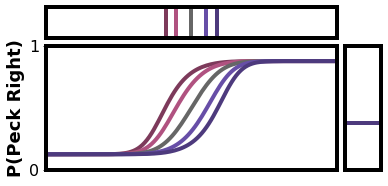

In [206]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 3),
    gridspec_kw={
        "height_ratios": [1, 4],
        "width_ratios": [8, 1],
        "hspace": 0.1,
        "wspace": 0.05,
    },
)

ax = axs[0, 0]
ax.set_xticks([], [])
ax.set_yticks([])
plt.tick_params(axis="both", which="major", labelsize=16)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_xlim([0, 127])

ax = axs[0, 1]
ax.axis("off")

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_ylim([0, 1])

ax = axs[1, 0]
ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis="both", which="major", labelsize=16)


ax.set_xticks([], [])
ax.set_yticks([0, 1])
ax.set_xlim([0, 127])
ax.set_ylim([0, 1])
for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
        
params = {
    "sigma_likelihood": 10,  # std of gaussian for likelihood
    "beta_categorical_attention": 0,  # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue,
    "delta_cue_attention": 0,  # pct of time ignoring the cue
    "alpha_overall_attention": 0.25,  # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta
    "gamma_side_bias": 0.5,  # the direction of the random guess (side bias)
}
for ct in condition_types:
    decision, posterior_probability, likelihood = bayesian_model(params, x_true, prior_probability[ct], decision_boundary)
    ax.plot(x_true, decision, color = colors['cue']['L'][ct], lw= 4, label = ct)[0]
    
    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(x_true, decision)
    axs[0, 0].axvline(_inflection, color=colors["cue"]["L"][ct], lw=4)

    axs[1, 1].axhline(
        ((_max - _min) / 2), color=colors["cue"]["L"][ct], lw=4
    )
    # print((_min, _max, _inflection, _slope))
    
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'decision_integration_shift', save_pdf=True)
plt.show()

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


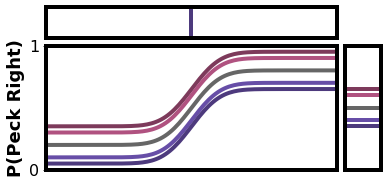

In [207]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 3),
    gridspec_kw={
        "height_ratios": [1, 4],
        "width_ratios": [8, 1],
        "hspace": 0.1,
        "wspace": 0.05,
    },
)

ax = axs[0, 0]
ax.set_xticks([], [])
ax.set_yticks([])
plt.tick_params(axis="both", which="major", labelsize=16)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_xlim([0, 127])

ax = axs[0, 1]
ax.axis("off")

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_ylim([0, 1])

ax = axs[1, 0]
ax.set_ylabel("P(Peck Right)", fontsize=18, fontweight="bold")
[i.set_linewidth(4) for i in ax.spines.values()]
plt.tick_params(axis="both", which="major", labelsize=16)


ax.set_xticks([], [])
ax.set_yticks([0, 1])
ax.set_xlim([0, 127])
ax.set_ylim([0, 1])
for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
        
params = {
    "sigma_likelihood": 10,  # std of gaussian for likelihood
    "beta_categorical_attention": 0,  # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue,
    "delta_cue_attention": 0,  # pct of time ignoring the cue
    "alpha_overall_attention": 0,  # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta
    "gamma_side_bias": 0.5,  # the direction of the random guess (side bias)
}
for ct in condition_types:

    decision, posterior_probability, likelihood = bayesian_model(
        params, x_true, prior_probability[0.5], decision_boundary
    )
    # decision_plots.append(axs[1].plot(x_true, (decision+ct)/2, color = colors['cue']['L'][ct], lw= 4, label = ct)[0])
    a = 0.6
    ax.plot(
        x_true,
        (decision * (a) + (1-ct) * (1 - a)),
        color=colors["cue"]["L"][ct],
        lw=4,
        label=ct,
    )[0]

    (
        (_min, _max, _inflection, _slope),
        results_logistic,
        y_model,
        r_squared,
    ) = fit_FourParameterLogistic(x_true, decision)
    axs[0, 0].axvline(_inflection, color=colors["cue"]["L"][ct], lw=4)

    axs[1, 1].axhline(
        ((_max - _min) / 2) * (a) + (1-ct) * (1 - a), color=colors["cue"]["L"][ct], lw=4
    )
    # print((_min, _max, _inflection, _slope))

    
ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'decision_no_integration_shift', save_pdf=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


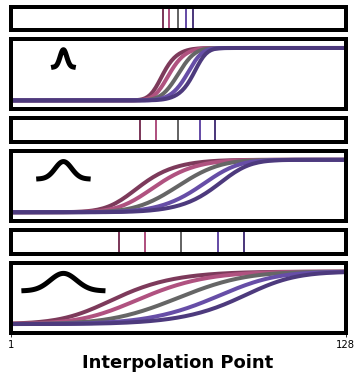

In [205]:
nex = 3
fig, axs = plt.subplots(nrows=nex*2, figsize=(6,6),gridspec_kw={'height_ratios': [1,3]*nex})

for axi, sig_likelihood in enumerate(np.linspace(5, 20, nex)):
    ax = axs[axi*2 + 1]
    params = {
        "sigma_likelihood": sig_likelihood,  # std of gaussian for likelihood
        "beta_categorical_attention": 0,  # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue,
        "delta_cue_attention": 0,  # pct of time ignoring the cue
        "alpha_overall_attention": 0.25,  # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta
        "gamma_side_bias": 0.5,  # the direction of the random guess (side bias)
    }
    for ct in condition_types:
        decision, posterior_probability, likelihood = bayesian_model(
            params, x_true, prior_probability[ct], decision_boundary
        )
        ax.plot(
            x_true,
            decision,
            color=colors["cue"]["L"][ct],
            lw=4,
            label=ct,
        )[0]
        
        (
        (_min, _max, _inflection, _slope),
            results_logistic,
            y_model,
            r_squared,
        ) = fit_FourParameterLogistic(x_true, decision)

        axs[axi*2].axvline(_inflection, color=colors["cue"]["L"][ct], lw=2)
        
    [i.set_linewidth(4) for i in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 127])
    ax.set_ylim([0, 1])
    
    mu = 0
    sigma = sig_likelihood / 4# math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    y = y / np.max(y) / 4
    ax.plot(x + 20, 0.6 + y, color = 'k', lw= 5)

    ax = axs[axi*2]
    [i.set_linewidth(4) for i in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, 127])
    ax.set_ylim([0, 1])
axs[axi*2+1].set_xticks([0,127])
axs[axi*2+1].set_xticklabels([1,128])
[i.set_linewidth(4) for i in ax.spines.values()];
ax.xaxis.set_tick_params(labelsize=16)
axs[axi*2+1].set_xlabel("Interpolation Point", fontsize=18, fontweight="bold");

ensure_dir(FIGURE_DIR / 'bayesian_model')
save_fig(FIGURE_DIR / 'bayesian_model' / 'decision_sigma_shift', save_pdf=True)
plt.show()